# Bayesian UQ-SINDy

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps
import arviz as az

In [3]:
# set seed for reproducibility
np.random.seed(123)

## Lotka-Volterra Predator-Prey Model

In this example, we generate the data using the Lotka-Volterra equations, which is a simplified model of Predator-Prey interactions. They specify a system of Ordinary Differential Equations (ODEs):
\begin{align}
\frac{dP}{dt} &= a P - b P Q\\
\frac{dQ}{dt} &= c P Q - d Q
\end{align}
where $P$ is the concentration of prey, $Q$ is the concentration of predators, $a$ is the birth rate of prey, $b$ is the death rate of prey, $c$ is the birth rate of predators and $d$ is the death rate of predators.

For more details, see e.g. Rockwood L. L. and Witt J. W. (2015). *Introduction to population ecology*. Wiley Blackwell, Chichester, West Sussex, UK, 2nd edition

In [4]:
# set up a class that defines the Lotka-Volterra equations
class PredatorPreyModel:
    def __init__(self, a=1.0, b=0.3, c=0.2, d=1.0):
        # internalise the model parameters.
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([self.a*y[0] - self.b*y[0]*y[1], self.c*y[0]*y[1] - self.d*y[1]])

    def solve(self, **kwargs):
        # solve the system of ODEs.
        return solve_ivp(self.dydx, **kwargs)

In [5]:
# set some hyperparameters.
t_span = [0, 30]
t_eval = np.linspace(*t_span, 50)
y0 = np.array([10,5])

# initialise the model and solve.
my_model = PredatorPreyModel()
sol = my_model.solve(t_span=t_span, y0=y0, t_eval=t_eval)

In [6]:
# the noise level.
noise = 0.5

# extract the timesteps and perturb the solution with noise.
t = sol.t
P = sol.y[0,:] + np.random.normal(scale=noise, size=sol.t.size)
Q = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

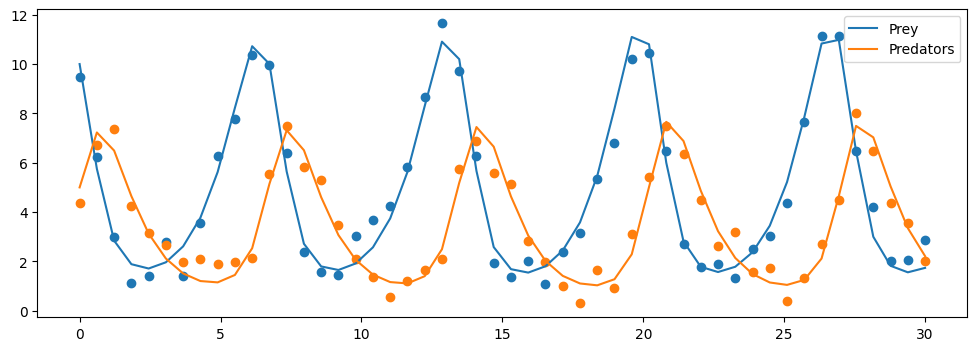

In [7]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(sol.t, sol.y[0,:], label = "Prey")
plt.scatter(t, P)
plt.plot(sol.t, sol.y[1,:], label="Predators")
plt.scatter(t, Q)
plt.legend()
plt.show()

## Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [8]:
# set sampler hyperparameters
sampling_seed = 123

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 500
    num_samples = 2000
    num_chains = 2

### Use the approximate (fast) method.

In [9]:
# initialise the approximate Sparse Bayesian Regression optimizer.
approximate_optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                                          num_samples=num_samples,
                                          mcmc_kwargs={"seed": sampling_seed,
                                                       "num_chains": num_chains},
                                          exact=False)

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
approximate_sindy = ps.SINDy(approximate_optimizer, feature_library, feature_names=['P', 'Q'])
approximate_sindy.fit(np.c_[P, Q], t=t)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR(exact=False, integrator_kwargs={},
                    mcmc_kwargs={'num_chains': 2, 'seed': 123},
                    num_samples=2000, num_warmup=500))

### Get MCMC diagnostics from the approximate method

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [10]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(approximate_optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.082,0.260,-0.311,0.652,0.015,0.011,240.0,445.0,1.14
"beta[0, 1]",0.948,0.137,0.703,1.246,0.006,0.005,436.0,776.0,1.11
"beta[0, 2]",-0.020,0.100,-0.202,0.199,0.004,0.003,121.0,641.0,1.01
"beta[0, 3]",-0.031,0.015,-0.060,-0.001,0.001,0.001,556.0,860.0,1.10
"beta[0, 4]",-0.154,0.027,-0.212,-0.105,0.001,0.001,593.0,892.0,1.20
"beta[0, 5]",-0.066,0.023,-0.108,-0.015,0.001,0.001,393.0,1101.0,1.08
"beta[1, 0]",-0.469,0.573,-1.361,0.205,0.226,0.168,10.0,206.0,1.14
"beta[1, 1]",-0.014,0.089,-0.214,0.155,0.003,0.003,401.0,931.0,1.05
"beta[1, 2]",-0.503,0.322,-0.961,0.019,0.122,0.090,9.0,124.0,1.16
"beta[1, 3]",0.019,0.011,0.001,0.041,0.001,0.000,252.0,1060.0,1.15


[]

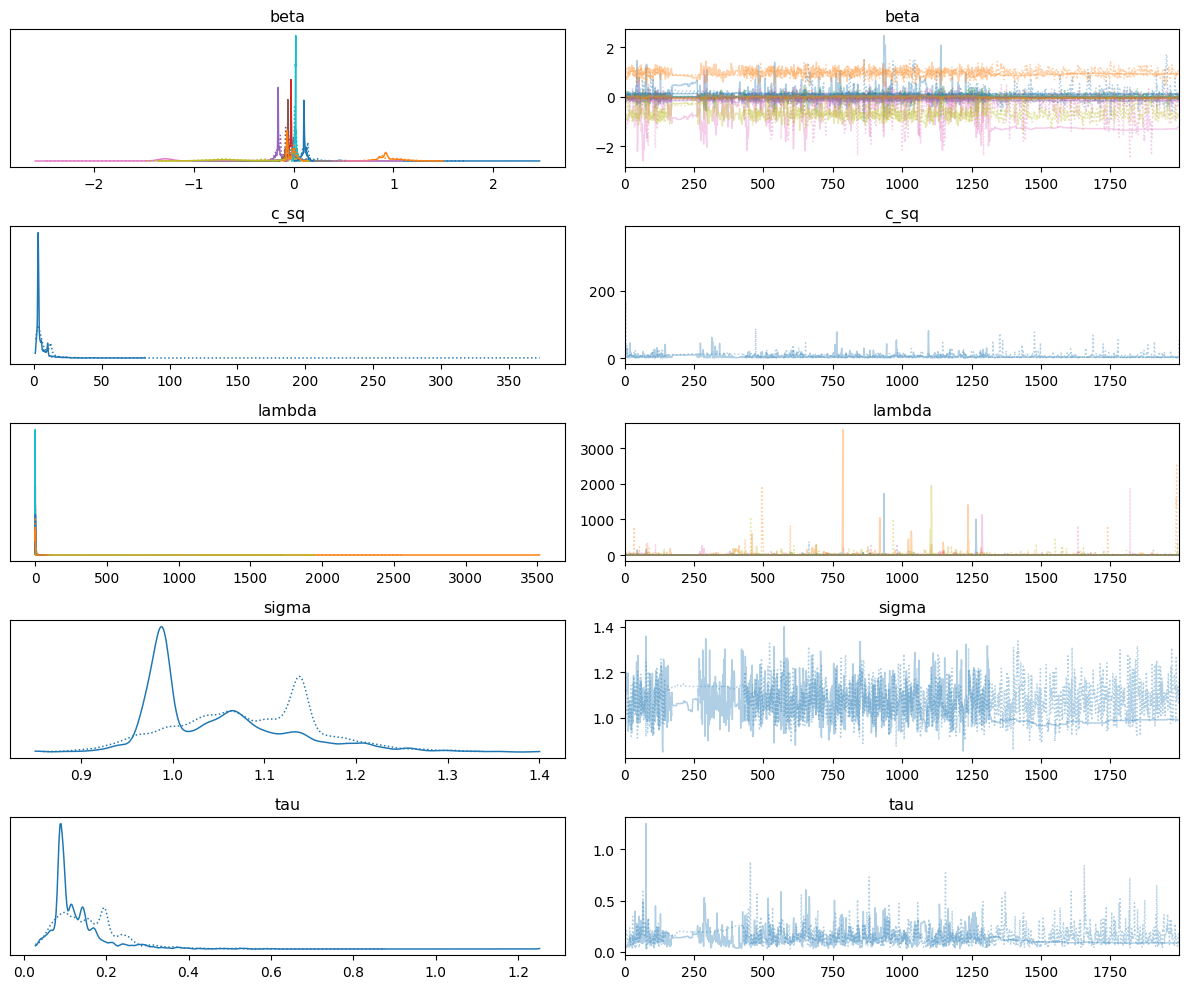

In [11]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()

In [12]:
posterior_mean = {key: value.mean(axis=0) for key, value in approximate_optimizer.mcmc_.get_samples().items()}

### Use the exact method.

In [13]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                              num_samples=num_samples,
                              mcmc_kwargs={"seed": sampling_seed,
                                           "num_chains": num_chains,
                                           "initial_values": posterior_mean},
                              integrator_kwargs={"dt": 0.5},
                              )

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
sindy = ps.SINDy(optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR(integrator_kwargs={'dt': 0.5},
                    mcmc_kwargs={'initial_values': {'beta': Array([[ 0.08202054,  0.94827581, -0.01963841, -0.03093006, -0.15414079,
        -0.06600033],
       [-0.46927052, -0.01356834, -0.50251257,  0.01896617,  0.10845485,
        -0.01463165]], dtype=flo...),
                                                    'c_sq': Array(6.75722661, dtype=float64),
                                                    'lambda': Array([[ 2.92118283, 20.27264287,  1.22562803,  0.99817721,  2.37856794,
         1.31744319],
       [ 6.17254636,  1.18987495, 10.83844919,  0.65150319,  1.71165937,
         0.91254329]], dtype=float64),
                                                    'sigma': Array(1.06404908, dtype=float64),
                                                    'tau': Array(0.14411412, dtype=float64)},
                                 'num_chains': 2, 'seed': 123},
                    num_samples=2000, num_warmup=500))

In [14]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, t_eval=t_eval)

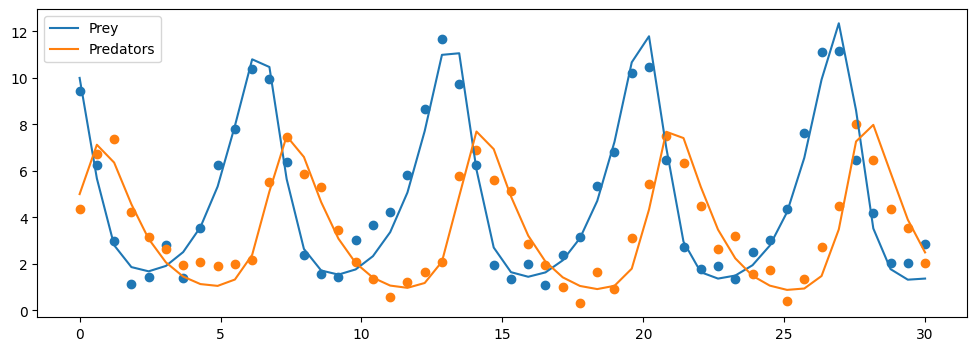

In [15]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "Prey")
plt.scatter(t, P)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="Predators")
plt.scatter(t, Q)

plt.legend()
plt.show()

### Get MCMC diagnostics from the exact method

In [16]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.126,0.341,-0.296,0.808,0.021,0.016,587.0,331.0,1.00
"beta[0, 1]",0.884,0.163,0.578,1.144,0.009,0.006,493.0,327.0,1.00
"beta[0, 2]",0.006,0.098,-0.174,0.196,0.004,0.003,968.0,560.0,1.00
"beta[0, 3]",0.016,0.017,-0.012,0.047,0.001,0.001,355.0,428.0,1.00
"beta[0, 4]",-0.315,0.032,-0.380,-0.253,0.001,0.001,556.0,255.0,1.00
"beta[0, 5]",0.004,0.020,-0.036,0.042,0.001,0.001,676.0,480.0,1.00
"beta[1, 0]",0.005,0.151,-0.293,0.304,0.004,0.004,1282.0,826.0,1.00
"beta[1, 1]",-0.004,0.057,-0.113,0.114,0.002,0.001,1116.0,1101.0,1.00
"beta[1, 2]",-1.007,0.115,-1.249,-0.802,0.004,0.003,908.0,764.0,1.00
"beta[1, 3]",0.004,0.008,-0.012,0.020,0.000,0.000,382.0,234.0,1.01


[]

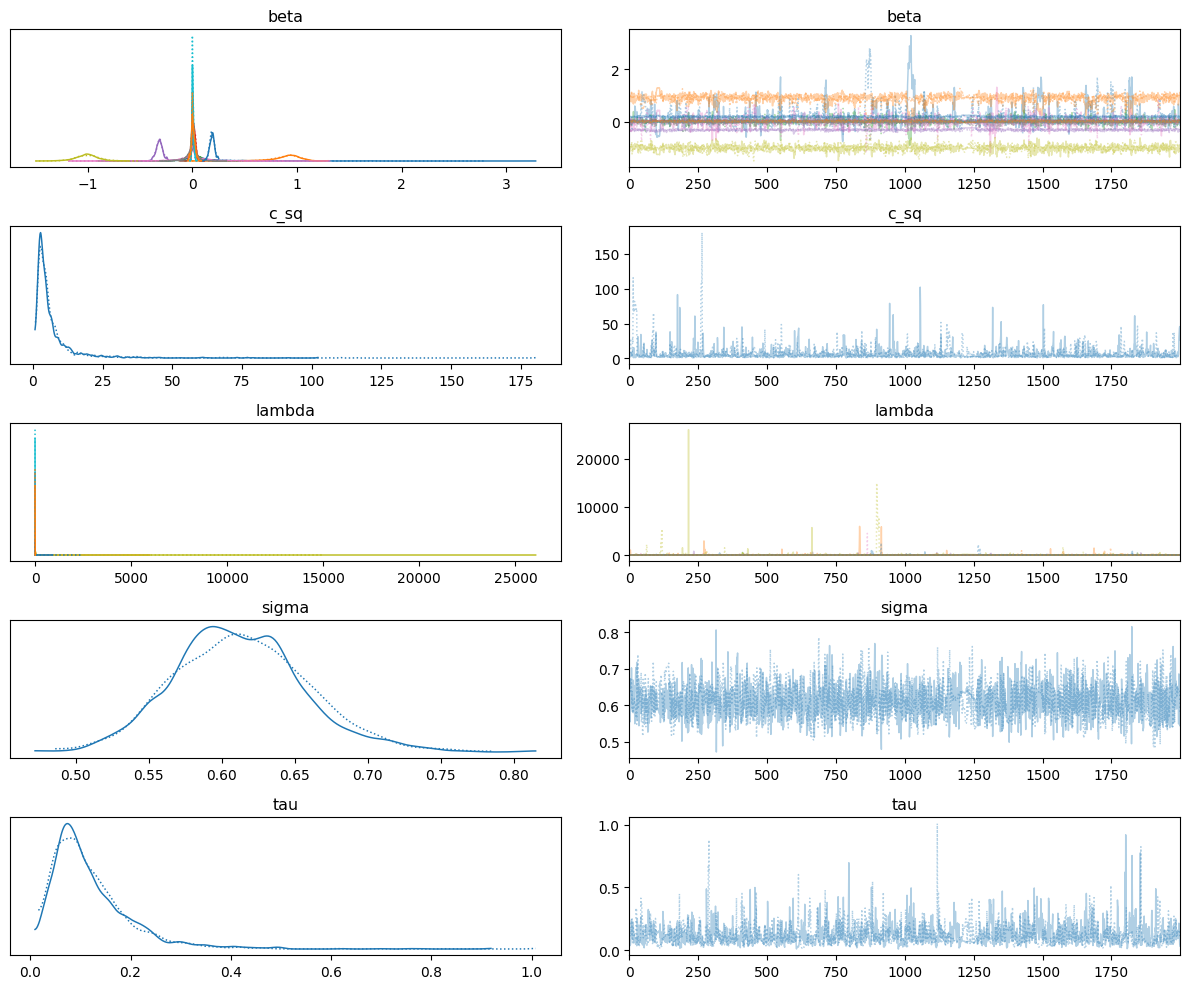

In [17]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()